In [2]:
import pandas as pd
pd.set_option('display.max_columns',400)
import warnings
import numpy as np
from sklearn.preprocessing import LabelEncoder
warnings.simplefilter('ignore')
import seaborn as sns
from sklearn.cluster import KMeans



train = pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e5/test.csv')
submission = pd.read_csv("/kaggle/input/playground-series-s5e5/sample_submission.csv")
train['Sex'] = train.Sex.map({'male':1,'female':0})
train.drop('id',axis=1, inplace=True)
test['Sex'] = test.Sex.map({'male':1,'female':0})
test.drop('id',axis=1, inplace=True)


In [3]:
numerical_features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

In [4]:
#train['HxD'] = train["Duration"] * train['Heart_Rate']
#test['HxD'] = test["Duration"] * test['Heart_Rate']

#train['Duration_sq'] = train['Duration']**2
#test['Duration_sq'] = test['Duration']**2

#train['Duration_digit_1']  = train['Duration'].astype(int).astype(str).str[0].astype(int) + 10
#test['Duration_digit_1']  = test['Duration'].astype(int).astype(str).str[0].astype(int)  + 10 

#train['HeightxD'] = train['Height'] * train['Duration']
#test['HeightxD'] = test['Height'] * test['Duration']




duration_counts_train = train['Duration'].value_counts()
train['Duration_freq'] = train['Duration'].map(duration_counts_train).astype('category')
duration_counts_test = train['Duration'].value_counts()
test['Duration_freq'] = test['Duration'].map(duration_counts_test).astype('category')



train['Body_Temp_37'] = (train['Body_Temp'] - 37).astype(int)
test['Body_Temp_37'] = (test['Body_Temp'] - 37).astype(int)


In [17]:
train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,HxD,Duration_sq,Duration_digit_1,HeightxD,Duration_freq,Body_Temp_37
0,1,36,189.0,82.0,26.0,101.0,41.0,150.0,2626.0,676.0,12,4914.0,28768,4
1,0,64,163.0,60.0,8.0,85.0,39.7,34.0,680.0,64.0,18,1304.0,26743,2
2,0,51,161.0,64.0,7.0,84.0,39.8,29.0,588.0,49.0,17,1127.0,25061,2
3,1,20,192.0,90.0,25.0,105.0,40.7,140.0,2625.0,625.0,12,4800.0,27765,3
4,0,38,166.0,61.0,25.0,102.0,40.6,146.0,2550.0,625.0,12,4150.0,27765,3


# FEATURE ENGINEERING 

In [ ]:
qcutla binle urettigin degiskenleri groupby yapacagin

In [5]:
def add_feature_cross_terms(df, main_features, numerical_features):
    df_new = df.copy()
    used_pairs = set()

    for f1 in main_features:
        for f2 in numerical_features:
            if f1 != f2 and frozenset([f1, f2]) not in used_pairs:
                col_name = f"{f1}_x_{f2}"
                df_new[col_name] = df_new[f1] * df_new[f2]
                used_pairs.add(frozenset([f1, f2]))

    return df_new


numerical_features = ['Age',
                      'Height', 'Weight', 
                      'Duration', 'Heart_Rate', #'Duration_sq', 
                      'Body_Temp',
                      #'Body_Temp_37',
                      
                     #'Body_Temp_minus_cube',
                     ]
main_features = ['Duration', 'Heart_Rate',
                 #'Body_Temp_minus_cube',
                 'Body_Temp',
            ]

train = add_feature_cross_terms(train, main_features, numerical_features)
test = add_feature_cross_terms(test, main_features, numerical_features)

In [5]:
train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,HxD,Duration_sq,Duration_digit_1,HeightxD,Duration_freq,Body_Temp_37,Duration_x_Age,Duration_x_Height,Duration_x_Weight,Duration_x_Heart_Rate,Duration_x_Duration_sq,Heart_Rate_x_Age,Heart_Rate_x_Height,Heart_Rate_x_Weight,Heart_Rate_x_Duration_sq
0,0,1,36,189.0,82.0,26.0,101.0,41.0,150.0,2626.0,676.0,12,4914.0,28768,4,936.0,4914.0,2132.0,2626.0,17576.0,3636.0,19089.0,8282.0,68276.0
1,1,0,64,163.0,60.0,8.0,85.0,39.7,34.0,680.0,64.0,18,1304.0,26743,2,512.0,1304.0,480.0,680.0,512.0,5440.0,13855.0,5100.0,5440.0
2,2,0,51,161.0,64.0,7.0,84.0,39.8,29.0,588.0,49.0,17,1127.0,25061,2,357.0,1127.0,448.0,588.0,343.0,4284.0,13524.0,5376.0,4116.0
3,3,1,20,192.0,90.0,25.0,105.0,40.7,140.0,2625.0,625.0,12,4800.0,27765,3,500.0,4800.0,2250.0,2625.0,15625.0,2100.0,20160.0,9450.0,65625.0
4,4,0,38,166.0,61.0,25.0,102.0,40.6,146.0,2550.0,625.0,12,4150.0,27765,3,950.0,4150.0,1525.0,2550.0,15625.0,3876.0,16932.0,6222.0,63750.0


**MULTIPLY**

In [ ]:
'''
import itertools
from tqdm import tqdm


numerical_features = [#'Age', 'Height', 'Weight',
                      'Sex',
                      'Duration', 'Heart_Rate', 'Body_Temp']
encoded_columns = []

# 2, 3, 4'lü kombinasyonlar
for r in [2, 3, 4]:
    for comb in tqdm(list(itertools.combinations(numerical_features, r)), desc=f"{r}-interaction"):
        name = '_'.join(comb)
        
        if r == 2:
            train[name] = train[comb[0]].astype(str) + '_' + train[comb[1]].astype(str)
            test[name] = test[comb[0]].astype(str) + '_' + test[comb[1]].astype(str)
        
        elif r == 3:
            train[name] = (train[comb[0]].astype(str) + '_' +
                           train[comb[1]].astype(str) + '_' +
                           train[comb[2]].astype(str))
            test[name] = (test[comb[0]].astype(str) + '_' +
                          test[comb[1]].astype(str) + '_' +
                          test[comb[2]].astype(str))
        
        elif r == 4:
            train[name] = (train[comb[0]].astype(str) + '_' +
                           train[comb[1]].astype(str) + '_' +
                           train[comb[2]].astype(str) + '_' +
                           train[comb[3]].astype(str))
            test[name] = (test[comb[0]].astype(str) + '_' +
                          test[comb[1]].astype(str) + '_' +
                          test[comb[2]].astype(str) + '_' +
                          test[comb[3]].astype(str))

        encoded_columns.append(name)

# Kategoriye çevir
train[encoded_columns] = train[encoded_columns].astype('category')
test[encoded_columns] = test[encoded_columns].astype('category')
'''

In [ ]:
train.head()

In [ ]:
train.shape

In [ ]:
'''
train['Metabolic_Eq'] = (train['Heart_Rate'] / (220 - train['Age'])) * train['Duration']
test['Metabolic_Eq'] = (test['Heart_Rate'] / (220 - test['Age'])) * test['Duration']


train['IntensityRatio'] = (train['Duration'] * train['Heart_Rate']) / train['Weight']
test['IntensityRatio'] = (test['Duration'] * test['Heart_Rate']) / test['Weight']


train['Poly_Dur_HR'] = (train['Heart_Rate'] ** 2) * (train['Duration'] ** 0.5)
test['Poly_Dur_HR'] = (test['Heart_Rate'] ** 2) * (test['Duration'] ** 0.5)

train['Poly_Dur_HR'] = np.log1p(train['Heart_Rate']) * train['Duration']**3
test['Poly_Dur_HR'] = np.log1p(test['Heart_Rate']) * test['Duration']**3
'''

In [ ]:
'''
kmeans = KMeans(n_clusters=4, random_state=42)
train['Cluster_Label'] = kmeans.fit_predict(train[['Duration', 'Heart_Rate', 'Body_Temp']])
test['Cluster_Label'] = kmeans.fit_predict(test[['Duration', 'Heart_Rate', 'Body_Temp']])

train = pd.get_dummies(train, columns=['Cluster_Label'], prefix='Cluster')
test = pd.get_dummies(test, columns=['Cluster_Label'], prefix='Cluster')



train['Heart_Rate_Rank'] = train['Heart_Rate'].rank(pct=True)
train['Body_Temp_Rank'] = train['Body_Temp'].rank(pct=True)
train['Duration'] = train['Duration'].rank(pct=True)

test['Heart_Rate_Rank'] = test['Heart_Rate'].rank(pct=True)
test['Body_Temp_Rank'] = test['Body_Temp'].rank(pct=True)
test['Heart_Rate_Rank'] = test['Heart_Rate'].rank(pct=True)
'''

In [6]:
# Normalize HR
train['HR_reserve'] = train['Heart_Rate'] / (220 - train['Age'])
test['HR_reserve'] = test['Heart_Rate'] / (220 - test['Age'])


In [7]:
import pandas as pd
import numpy as np
import itertools

def feature_eng(df):
#    df['Round_1'] = df['Duration'].round() ** 2
  #  df['Round_2'] = df['Heart_Rate'].round() ** 2
   # df['Round_3'] = df['Body_Temp'].round() ** 2

    df['Round_1'] = df['Duration'].round() // 3
    df['Round_2'] = df['Heart_Rate'].round() // 3
    df['Round_3'] = df['Body_Temp'].round() // 3
# Örnek olarak 'Duration' değişkeni üzerinden
    #df['First_Digit-h']  = df['Heart_Rate'].astype(int).astype(str).str[0].astype(int)
    df['Second_Digit-h'] = df['Heart_Rate'].astype(int).astype(str).str[1].astype(int)
# Örnek olarak 'Duration' değişkeni üzerinden
    df['First_Digit-b']  = df['Body_Temp'].astype(int).astype(str).str[0].astype(int)
    df['Second_Digit-b'] = df['Body_Temp'].astype(int).astype(str).str[1].astype(int)
     
    df['First_Digit-d']  = df['Duration'].astype(int).astype(str).str[0].astype(int)
    #df['Second_Digit-d'] = df['Duration'].astype(int).astype(str).str[1].astype(int)
    return df

train = feature_eng(train)
test  = feature_eng(test)


#le = LabelEncoder()
#train['Sex'] = le.fit_transform(train['Sex'])
#test['Sex'] = le.transform(test['Sex'])

#train["Sex"] = train["Sex"].astype("category")
#test["Sex"] = test["Sex"].astype("category")

#X = train.drop(columns=["id"])
#y = np.log1p(train["Calories"])
#X_test = test.drop(columns=["id"])

**SQUARES**

In [8]:
#train['Duration_sq'] = train['Duration']**2
#test['Duration_sq'] = test['Duration']**2

train['Heart_Rate_sq'] = train['Heart_Rate']**2
test['Heart_Rate_sq'] = test['Heart_Rate']**2

train['Body_Temp_sq'] = train['Body_Temp']**2
test['Body_Temp_sq'] = test['Body_Temp']**2

In [ ]:
train.shape

In [ ]:
train.head()

# MODEL

In [ ]:
'''
import numpy as np

df_corr = train.select_dtypes(include=np.number).copy()
target_col = 'Calories'
to_drop = []

while True:
    corr_matrix = df_corr.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    max_corr = upper.max().max()

    if max_corr > 0.99:
        # En yüksek korelasyon çiftini bul
        high_corr_pair = np.where(upper == max_corr)
        i, j = high_corr_pair[0][0], high_corr_pair[1][0]
        col1 = upper.index[i]
        col2 = upper.columns[j]

        # Silinecek olanı seç
        if col1 == target_col:
            drop_col = col2
        elif col2 == target_col:
            drop_col = col1
        else:
            drop_col = col2  # örnek olarak col2

        keep_col = col1 if drop_col == col2 else col2

        print(f"Kaldırılıyor: {drop_col}  ↔  {keep_col}  (korelasyon: {max_corr:.4f})")
        to_drop.append(drop_col)
        df_corr = df_corr.drop(columns=[drop_col])
    else:
        break

print("\nToplam çıkarılan değişken sayısı:", len(to_drop))
print("Çıkarılanlar:", to_drop)
'''

In [ ]:
train.head()

In [ ]:
train.shape

In [32]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
from itertools import combinations
from tqdm import tqdm
from cuml.preprocessing.TargetEncoder import TargetEncoder

# 1) Parametreleri tanımlayın
FEATURES = [col for col in train.columns if col not in ['id', 'Calories']]
TARGET   = "Calories"
FOLDS    = 5
SEED     = 42

# 2) Modeli tanımlayın
model = XGBRegressor(
    max_depth=8,
    colsample_bytree=0.65,
    subsample=0.9,
    n_estimators=3000,
    learning_rate=0.02,
    max_delta_step=1,
    early_stopping_rounds=100,
    eval_metric='rmse',
    random_state=SEED,
    tree_method='gpu_hist'
)

# 3) Sonuçları saklayacağımız yapı
oof_preds = np.zeros(len(train))
test_preds = np.zeros(len(test))

# 4) CV döngüsü
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold, (tr_idx, val_idx) in enumerate(kf.split(train), start=1):
    print(f"\n--- Fold {fold}/{FOLDS} ---")
    start_time = time.time()
    
    # 4a) Eğitim ve validasyon setlerini oluştur
    X_tr, y_tr = train.loc[tr_idx, FEATURES], train.loc[tr_idx, TARGET]
    X_val, y_val = train.loc[val_idx, FEATURES], train.loc[val_idx, TARGET]
    
    # 4b) Log dönüşümü (opsiyonel ama orijinal kodunuzda vardı)
    y_tr_log  = np.log1p(y_tr)
    y_val_log = np.log1p(y_val)
    
    # 4c) Modeli eğit
    model.fit(
        X_tr, y_tr_log,
        eval_set=[(X_val, y_val_log)],
        verbose=100
    )
    
    # 4d) Tahminleri al
    oof_fold = model.predict(X_val)
    test_fold = model.predict(test[FEATURES])
    
    # 4e) OOF ve test sonuçlarını kaydet
    oof_preds[val_idx] += oof_fold
    test_preds += test_fold / FOLDS
    
    # 4f) Fold RMSLE hesapla ve göster
    rmsle = np.sqrt(
        mean_squared_log_error(
            y_val, 
            np.expm1(oof_fold)
        )
    )
    print(f"Fold {fold} RMSLE: {rmsle:.4f}")
    print(f"Fold süresi: {time.time() - start_time:.1f} sn")

# 5) CV skoru
mean_rmsle = np.sqrt(
    mean_squared_log_error(
        train[TARGET], 
        np.expm1(oof_preds)
    )
)
print(f"\nGenel CV RMSLE: {mean_rmsle:.4f}")

# 6) Submission için sonuç hazırlama
submission = pd.DataFrame({
    "id": test["id"],
    "Calories": np.expm1(test_preds)
})


--- Fold 1/5 ---


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Duration_freq: category


=== Training XGBoost ===
--- Fold 1/5 ---
xtr,xval,ytr,yval((600000, 32), (150000, 32), (600000, 1), (150000, 1))
X_test (250000, 31)
encode sonrasi xtr,xval,ytr,yval((600000, 35), (150000, 35), (600000, 1), (150000, 1))
[0]	validation_0-rmse:0.94873
[100]	validation_0-rmse:0.17955
[200]	validation_0-rmse:0.06387
[300]	validation_0-rmse:0.05938
[400]	validation_0-rmse:0.05927
[495]	validation_0-rmse:0.05930
Fold 1 RMSLE: 0.05926
Training time: 24.0 sec
--- Fold 2/5 ---
xtr,xval,ytr,yval((600000, 32), (150000, 32), (600000, 1), (150000, 1))
X_test (250000, 31)
encode sonrasi xtr,xval,ytr,yval((600000, 35), (150000, 35), (600000, 1), (150000, 1))
[0]	validation_0-rmse:0.95120
[100]	validation_0-rmse:0.18127
[200]	validation_0-rmse:0.06496
[300]	validation_0-rmse:0.06036
[400]	validation_0-rmse:0.06023
[500]	validation_0-rmse:0.06025
[505]	validation_0-rmse:0.06026
Fold 2 RMSLE: 0.06022
Training time: 22.7 sec
--- Fold 3/5 ---
xtr,xval,ytr,yval((600000, 32), (150000, 32), (600000, 1), (1

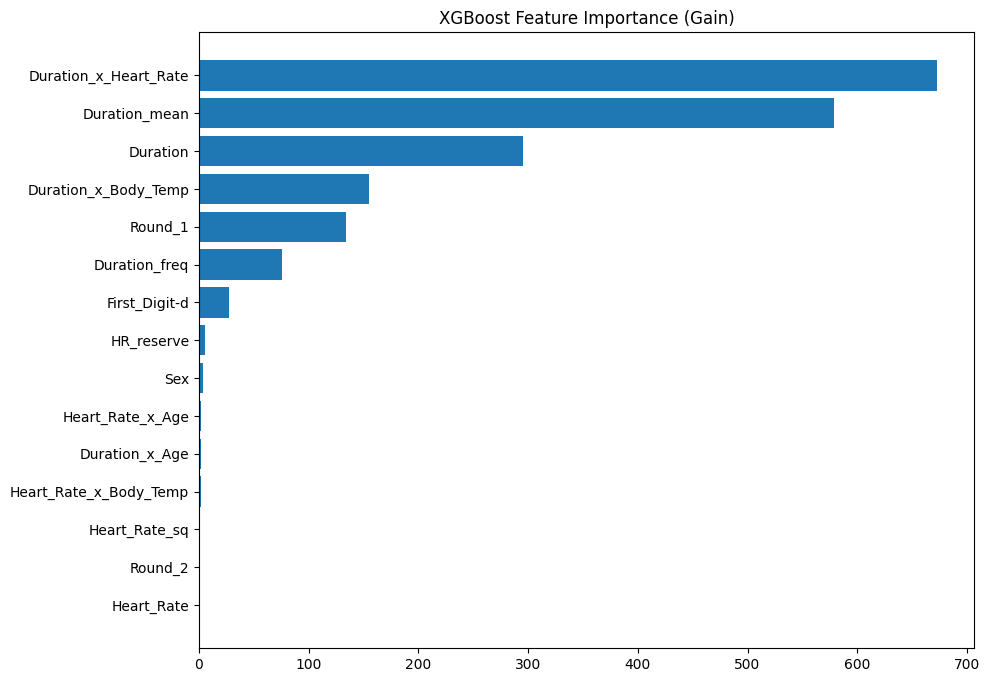


XGBoost - Mean RMSLE: 0.05963 ± 0.0004


In [9]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import gc
import matplotlib.pyplot as plt
import optuna


cat_cols = train.select_dtypes(include='category').columns.tolist()


models = {
   # 'CatBoost' : CatBoostRegressor(
     #   iterations=3000, learning_rate=0.01, 
       # depth=8,                         # max_depth karşılığı
            #rsm=0.55,                        # colsample_bytree karşılığı
            #subsample=0.7,                   # bayesian ile calisir
       # bootstrap_type='Bayesian',
       # random_seed=42, early_stopping_rounds=100,
        #eval_metric='RMSE',
    #cat_features=cat_cols, verbose=100, task_type='GPU'
    #),
    'XGBoost': XGBRegressor(
        max_depth=10, colsample_bytree=0.70, subsample=0.9,
        n_estimators=3000, learning_rate=0.02,
        max_delta_step = 1,
        early_stopping_rounds=100,
        eval_metric='rmse', enable_categorical=True,
        random_state=42,
        tree_method='gpu_hist'
    ),
}

# 1) Parametreleri tanımlayın
FEATURES = [col for col in train.columns if col not in ['id', 'Calories']]
TARGET        = ["Calories"]
GROUPING_VARS = ['Age',
                 #'Sex',
                 #'Height', 
                 #'Weight', 
                 'Duration',
                 #'Body_Temp_37',
                 #'Duration_cb',                 
                 #'Duration_sq',
                 'Heart_Rate',
                 'Body_Temp',
                 #'Body_Temp_minus_cube',
                ] 
#+ train.columns[23:].tolist()

                
STATS         = ['mean', 
                 #'std',
                 #'median', 
                 #'max','min',
                 #'sum',
                 #'sem',  #sem standart hata
                 #'skew',
                 #count'
                ] 
FOLDS         = 5

# 2) Veri setlerini sıfırdan indeksleyip kopyalayın
#train = train.copy()
#test  = test.copy()




results = {}
for name in models:
    results[name] = {
            'oof': np.zeros(len(train)),         
            'pred': np.zeros(len(test)),           
            'rmsle': []                            
        }

    # 4) Modeling loop
for name, model in models.items():
    print(f"\n=== Training {name} ===")
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
        # Her fold için ayırma
    for fold, (tr_idx, val_idx) in enumerate(kf.split(train), start=1):
        print(f"--- Fold {fold}/{FOLDS} ---")
        start_time = time.time()

        trainn = train.copy()
        
            # 4a) Ham X_train, y_train, X_valid, y_valid
        X_tr = trainn.loc[tr_idx, FEATURES+['Calories']].reset_index(drop=True)
        y_tr = trainn.loc[tr_idx, ['Calories']].reset_index(drop=True)
        
        X_val = trainn.loc[val_idx, FEATURES+['Calories']].reset_index(drop=True)
        y_val = trainn.loc[val_idx, ['Calories']].reset_index(drop=True)

        y_tr = np.log1p(y_tr)
        y_val = np.log1p(y_val)
               
        X_test = test.reset_index(drop=True).copy()
        
        print(f'xtr,xval,ytr,yval{X_tr.shape,X_val.shape,y_tr.shape, y_val.shape}')
        print(f'X_test {X_test.shape}')
            #TARGET ENCODE
        for col in GROUPING_VARS:
                # Eğitim fold'undan agg tablosu
            agg = ( X_tr.groupby(col)["Calories"].agg(STATS).reset_index() )
            agg.columns = [col] + [f"{col}_{stat}" for stat in STATS]

            X_tr  = X_tr.merge(agg, on=col, how='left')
            X_val = X_val.merge(agg, on=col, how='left')
            X_test= X_test.merge(agg, on=col, how='left')


        X_tr.drop('Calories',axis=1,inplace=True)
        X_val.drop('Calories',axis=1,inplace=True)

            #print(f'xtr,xval,ytr,yval{X_tr.shape,X_val.shape,y_tr.shape, y_val.shape}')

            #X_tr = train.iloc[tr_idx][FEATURES].drop(columns='Calories').merge(agg, on=col, how='left')
            #X_val = train.iloc[val_idx][FEATURES].drop(columns='Calories').merge(agg, on=col, how='left')
            #X_test= X_test.merge(agg, on=col, how='left')

        print(f'encode sonrasi xtr,xval,ytr,yval{X_tr.shape,X_val.shape,y_tr.shape, y_val.shape}')
        
            # 4g) Modeli eğit
        if name == 'XGBoost':
            model.fit(X_tr,
                      #_enc, 
                      y_tr,
                      eval_set=[(X_val,
                                 #_enc
                                  y_val)],
                      verbose=100)
    
        oof_pred  = model.predict(X_val)
        test_pred = model.predict(X_test)
        
            # 4i) Sonuçları kaydet
        results[name]['oof'][val_idx] = oof_pred
        results[name]['pred']         += test_pred / FOLDS
        
            # 4j) RMSLE skoru
        rmsle = np.sqrt(
            mean_squared_log_error(
                np.expm1(y_val), 
                np.expm1(oof_pred)
            )
        )
        results[name]['rmsle'].append(rmsle)
        
        print(f"Fold {fold} RMSLE: {rmsle:.5f}")
       
        
        
        print(f"Training time: {time.time() - start_time:.1f} sec")
            #Belleği temizle
        del X_tr, X_val, y_tr, y_val, oof_pred, test_pred, 
            #model
            #gc.collect()



    
    print(f'feature importance grafigi')
    importance = model.get_booster().get_score(importance_type='gain')
    importance_df = pd.DataFrame({
                'Feature': list(importance.keys()),
                'Importance': list(importance.values())
            }).sort_values(by='Importance', ascending=False).head(15)

    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.gca().invert_yaxis()
    plt.title('XGBoost Feature Importance (Gain)')
    plt.show()

        
mean_rmsle = np.mean(results[name]['rmsle'])
std_rmsle  = np.std(results[name]['rmsle'])
print(f"\n{name} - Mean RMSLE: {mean_rmsle:.5f} ± {std_rmsle:.4f}")

In [ ]:
### OOF ve Submission çıktıları
for name in models:
    # OOF tahminlerini kaydet
    np.save(f"{name}_oof.npy", results[name]['oof'])

    # Submission dosyası oluştur
    submission = pd.DataFrame({
        'Id': X_test.index,
        'Calories': np.expm1(results[name]['pred'])  # log1p dönüşüm varsa kullanılır
    })
    submission.to_csv(f"{name}_submission.csv", index=False)

    print(f"Saved: {name}_oof.npy & {name}_submission.csv")

In [ ]:
submission = pd.read_csv("/kaggle/input/playground-series-s5e5/sample_submission.csv")

# Her model için tahminleri ID ile eşle
for name in models:
    # OOF tahminlerini kaydet
    np.save(f"{name}_oof.npy", results[name]['oof'])

    # Yeni submission oluştur (ID'leri sample_submission'dan al!)
    sub = submission.copy()
    sub['Calories'] = np.expm1(results[name]['pred'])  # log1p dönüşümü varsa

    # Kaydet
    sub.to_csv(f"{name}_submission.csv", index=False)

    print(f"Saved: {name}_oof.npy & {name}_submission.csv")
